https://www.sciencedirect.com/science/article/pii/S2211812814005318

In [31]:
# import dependencies
%matplotlib inline
from keras.models import Sequential
from keras.activations import *
from keras.layers import *
from keras.losses import *
from keras.optimizers import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import talos as ta
import warnings
warnings.filterwarnings("ignore")

# suppress NumPy arrays scientific notation and round decimals to three places
np.set_printoptions(suppress=True)
np.printoptions(precision=3, suppress=True)

print('Dependency Version:\n')
print('Keras', keras.__version__)
print('Numpy', np.__version__)
print('Pandas', pd.__version__)
print('Seaborn', seaborn.__version__)
print('Sklearn', sklearn.__version__)
print('Talos', ta.__version__)

In [32]:
# import training data
data = pd.read_csv('data.txt', delim_whitespace=True, encoding='ISO-8859-1')
data.drop(columns=['Sr._No.'], inplace=True)

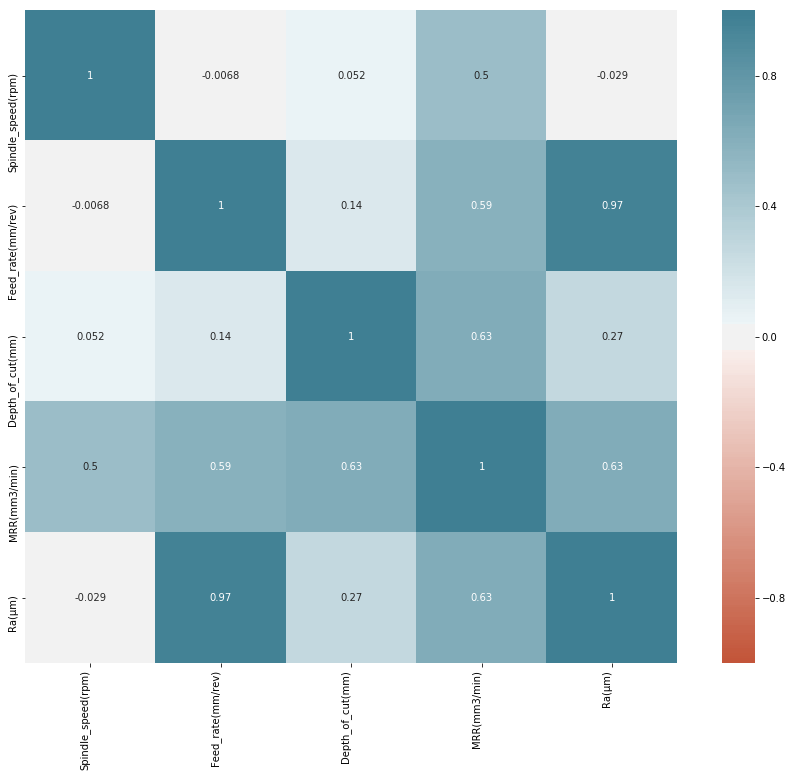

In [33]:
# a look at the overall correlation between training and testing data
heat_data = data
plt.figure(figsize=(16, 12))
corr = heat_data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);
plt.savefig('heatmap')

In [34]:
# change the dataframe into a NumPy array
np_data = data.values

In [35]:
# Transforms features by scaling each feature to a given range, -1 and 1 in this case
MinMax_scaler = MinMaxScaler(feature_range=(-1, 1))
np_data_MinMax = MinMax_scaler.fit_transform(np_data)

In [36]:
# Standardize features by removing the mean and scaling to unit variance
Standard_scaler = StandardScaler()
np_data_Standard = Standard_scaler.fit_transform(np_data)

In [37]:
# split the scaled data into training, testing, and validation sets
train_features_MinMax = np_data_MinMax[0:27 , 3:5]
test_features_MinMax = np_data_MinMax[28:32, 3:5]
validation_features_MinMax = np_data_MinMax[27, 3:5]
train_labels_MinMax = np_data_MinMax[0:27, 0:3]
test_labels_MinMax = np_data_MinMax[28:32, 0:3]
validation_labels_MinMax = np_data_MinMax[27, 0:3]

# reshape the validation data because it's only one row
validation_features_MinMax = validation_features_MinMax.reshape(1, -1)
validation_labels_MinMax = validation_labels_MinMax.reshape(1, -1)

In [38]:
# split the scaled data into training, testing, and validation sets
train_features_Standard = np_data_Standard[0:27 , 3:5]
test_features_Standard = np_data_Standard[28:32, 3:5]
validation_features_Standard = np_data_Standard[27, 3:5]
train_labels_Standard = np_data_Standard[0:27, 0:3]
test_labels_Standard = np_data_Standard[28:32, 0:3]
validation_labels_Standard = np_data_Standard[27, 0:3]

# reshape the validation data because it's only one row
validation_features_Standard = validation_features_Standard.reshape(1, -1)
validation_labels_Standard = validation_labels_Standard.reshape(1, -1)

In [39]:
# combining original the testing group to compare against rescaled groups below
np_test_data = np.concatenate([np_data[28:32, 0:3], np_data[28:32, 3:5]], axis=1)
np_test_data

array([[1100.  ,    0.05,    0.69, 2020.44,    0.29],
       [1095.  ,    0.15,    1.2 , 6054.12,    1.87],
       [1097.  ,    0.13,    1.14, 5329.21,    1.54],
       [1094.  ,    0.12,    1.15, 5197.29,    1.45]])

In [40]:
# combine the MinMax testing group and rescale
test_data_MinMax = np.concatenate([test_labels_MinMax, test_features_MinMax], axis=1)
MinMax_scaler.inverse_transform(test_data_MinMax)

array([[1100.  ,    0.05,    0.69, 2020.44,    0.29],
       [1095.  ,    0.15,    1.2 , 6054.12,    1.87],
       [1097.  ,    0.13,    1.14, 5329.21,    1.54],
       [1094.  ,    0.12,    1.15, 5197.29,    1.45]])

In [41]:
# combine the Standard testing group and rescale
test_data_Standard = np.concatenate([test_labels_Standard, test_features_Standard], axis=1)
Standard_scaler.inverse_transform(test_data_Standard)

array([[1100.  ,    0.05,    0.69, 2020.44,    0.29],
       [1095.  ,    0.15,    1.2 , 6054.12,    1.87],
       [1097.  ,    0.13,    1.14, 5329.21,    1.54],
       [1094.  ,    0.12,    1.15, 5197.29,    1.45]])

In [42]:
# parameters to try during Talos optimization
p = {
    'first_neuron': [8, 12, 24],
    'second_neuron': [36, 48, 62],
    'third_neuron': [36, 48, 62],
    'fourth_neuron': [8, 12, 24],
    'batch_size': [10, 20, 30],
    'activation': [relu,
                   tanh,
                   linear],
    'optimizer' : ['Adam',],
    'loss' : [mean_squared_error,]
}

In [43]:
def MinMax_ann(train_features, train_labels, test_features, test_labels, params):
    
    # replace the hyperparameter inputs with references to params dictionary 
    model = Sequential()
    model.add(Dense(params['first_neuron'], input_dim=2, activation=params['activation']))
    model.add(Dense(params['second_neuron'], activation=params['activation']))
    model.add(Dense(params['third_neuron'], activation=params['activation']))
    model.add(Dense(params['fourth_neuron'], activation=params['activation']))
    model.add(Dense(3, activation='linear'))
    model.compile(loss=params['loss'], optimizer=params['optimizer'], metrics=['accuracy'])
    
    # make sure history object is returned by model.fit()
    out = model.fit(train_features_MinMax, train_labels_MinMax,
                    epochs=1000,
                    batch_size=params['batch_size'],
                    verbose=0,
                    validation_data=[test_features_MinMax, test_labels_MinMax])
    
    # model output
    return out, model

In [44]:
def Standard_ann(train_features, train_labels, test_features, test_labels, params):
    
    # replace the hyperparameter inputs with references to params dictionary 
    model = Sequential()
    model.add(Dense(params['first_neuron'], input_dim=2, activation=params['activation']))
    model.add(Dense(params['second_neuron'], activation=params['activation']))
    model.add(Dense(params['third_neuron'], activation=params['activation']))
    model.add(Dense(params['fourth_neuron'], activation=params['activation']))
    model.add(Dense(3, activation='linear'))
    model.compile(loss=params['loss'], optimizer=params['optimizer'], metrics=['accuracy'])
    
    # make sure history object is returned by model.fit()
    out = model.fit(train_features_Standard, train_labels_Standard,
                    epochs=1000,
                    batch_size=params['batch_size'],
                    verbose=0,
                    validation_data=[test_features_Standard, test_labels_Standard])
    
    # model output
    return out, model

In [45]:
# combine MinMax training and test features, and training and test labels for Talos experiment
features_MinMax = np.concatenate((train_features_MinMax, test_features_MinMax), axis=0)
labels_MinMax = np.concatenate((train_labels_MinMax, test_labels_MinMax), axis=0)

In [46]:
# combine Standard training and test features, and training and test labels for Talos experiment
features_Standard = np.concatenate((train_features_Standard, test_features_Standard), axis=0)
labels_Standard = np.concatenate((train_labels_Standard, test_labels_Standard), axis=0)

In [47]:
# run the Talos experiment on MinMax data
MinMax_t = ta.Scan(features_MinMax, labels_MinMax, 
            params=p, 
            model=MinMax_ann,
            )

100%|██████████████████████████████████████████████████████████████████████████████| 729/729 [1:30:06<00:00,  2.43s/it]


In [48]:
# run the Talos experiment on Standard data
MinMax_t = ta.Scan(features_Standard, labels_Standard, 
            params=p, 
            model=Standard_ann,
            )

100%|████████████████████████████████████████████████████████████████████████████████| 729/729 [40:45<00:00,  2.46s/it]


In [55]:
# Define the MinMax model
MinMax_model = Sequential()
MinMax_model.add(Dense(24, input_dim=2, activation='relu'))
MinMax_model.add(Dense(36, activation='relu'))
MinMax_model.add(Dense(62, activation='relu'))
MinMax_model.add(Dense(8, activation='relu'))
MinMax_model.add(Dense(3, activation='linear'))
MinMax_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

MinMax_model.fit(train_features_MinMax,
                 train_labels_MinMax,
                 validation_data=(test_features_MinMax, test_labels_MinMax),
                 batch_size=20,
                 epochs=1000)

Train on 27 samples, validate on 4 samples
Epoch 1/1000
27/27 [==============================] - ETA: 0s - loss: 0.6824 - acc: 0.550 - 1s 30ms/step - loss: 0.6605 - acc: 0.4815 - val_loss: 0.6673 - val_acc: 0.7500
Epoch 2/1000
27/27 [==============================] - ETA: 0s - loss: 0.6175 - acc: 0.500 - 0s 0us/step - loss: 0.6479 - acc: 0.4444 - val_loss: 0.6563 - val_acc: 0.7500
Epoch 3/1000
27/27 [==============================] - ETA: 0s - loss: 0.6521 - acc: 0.600 - 0s 0us/step - loss: 0.6360 - acc: 0.5926 - val_loss: 0.6453 - val_acc: 0.7500
Epoch 4/1000
27/27 [==============================] - ETA: 0s - loss: 0.6414 - acc: 0.650 - 0s 579us/step - loss: 0.6239 - acc: 0.6296 - val_loss: 0.6326 - val_acc: 0.7500
Epoch 5/1000
27/27 [==============================] - ETA: 0s - loss: 0.5958 - acc: 0.650 - 0s 579us/step - loss: 0.6127 - acc: 0.6296 - val_loss: 0.6207 - val_acc: 0.7500
Epoch 6/1000
27/27 [==============================] - ETA: 0s - loss: 0.5586 - acc: 0.650 - 0s 578us/s

27/27 [==============================] - ETA: 0s - loss: 0.2211 - acc: 0.650 - 0s 0us/step - loss: 0.2897 - acc: 0.5926 - val_loss: 0.1409 - val_acc: 0.7500
Epoch 49/1000
27/27 [==============================] - ETA: 0s - loss: 0.3038 - acc: 0.600 - 0s 0us/step - loss: 0.2879 - acc: 0.5926 - val_loss: 0.1366 - val_acc: 0.7500
Epoch 50/1000
27/27 [==============================] - ETA: 0s - loss: 0.2825 - acc: 0.600 - 0s 0us/step - loss: 0.2857 - acc: 0.6296 - val_loss: 0.1307 - val_acc: 0.7500
Epoch 51/1000
27/27 [==============================] - ETA: 0s - loss: 0.3297 - acc: 0.550 - 0s 0us/step - loss: 0.2817 - acc: 0.6296 - val_loss: 0.1278 - val_acc: 0.7500
Epoch 52/1000
27/27 [==============================] - ETA: 0s - loss: 0.2728 - acc: 0.600 - 0s 579us/step - loss: 0.2792 - acc: 0.5926 - val_loss: 0.1274 - val_acc: 0.7500
Epoch 53/1000
27/27 [==============================] - ETA: 0s - loss: 0.2259 - acc: 0.600 - 0s 0us/step - loss: 0.2768 - acc: 0.5926 - val_loss: 0.1296 - va

Epoch 96/1000
27/27 [==============================] - ETA: 0s - loss: 0.2118 - acc: 0.550 - 0s 579us/step - loss: 0.2458 - acc: 0.5926 - val_loss: 0.1329 - val_acc: 0.2500
Epoch 97/1000
27/27 [==============================] - ETA: 0s - loss: 0.2310 - acc: 0.600 - 0s 0us/step - loss: 0.2455 - acc: 0.5926 - val_loss: 0.1317 - val_acc: 0.2500
Epoch 98/1000
27/27 [==============================] - ETA: 0s - loss: 0.2475 - acc: 0.650 - 0s 579us/step - loss: 0.2455 - acc: 0.6667 - val_loss: 0.1348 - val_acc: 0.2500
Epoch 99/1000
27/27 [==============================] - ETA: 0s - loss: 0.2384 - acc: 0.750 - 0s 0us/step - loss: 0.2459 - acc: 0.6667 - val_loss: 0.1386 - val_acc: 0.2500
Epoch 100/1000
27/27 [==============================] - ETA: 0s - loss: 0.1832 - acc: 0.650 - 0s 0us/step - loss: 0.2460 - acc: 0.6296 - val_loss: 0.1413 - val_acc: 0.2500
Epoch 101/1000
27/27 [==============================] - ETA: 0s - loss: 0.2453 - acc: 0.600 - 0s 579us/step - loss: 0.2450 - acc: 0.6296 - v

27/27 [==============================] - ETA: 0s - loss: 0.2356 - acc: 0.650 - 0s 0us/step - loss: 0.2351 - acc: 0.5926 - val_loss: 0.1400 - val_acc: 0.2500
Epoch 144/1000
27/27 [==============================] - ETA: 0s - loss: 0.2069 - acc: 0.700 - 0s 578us/step - loss: 0.2351 - acc: 0.5926 - val_loss: 0.1399 - val_acc: 0.2500
Epoch 145/1000
27/27 [==============================] - ETA: 0s - loss: 0.2081 - acc: 0.700 - 0s 0us/step - loss: 0.2357 - acc: 0.5926 - val_loss: 0.1372 - val_acc: 0.2500
Epoch 146/1000
27/27 [==============================] - ETA: 0s - loss: 0.2740 - acc: 0.550 - 0s 0us/step - loss: 0.2354 - acc: 0.5926 - val_loss: 0.1318 - val_acc: 0.2500
Epoch 147/1000
27/27 [==============================] - ETA: 0s - loss: 0.1912 - acc: 0.700 - 0s 579us/step - loss: 0.2351 - acc: 0.5926 - val_loss: 0.1259 - val_acc: 0.2500
Epoch 148/1000
27/27 [==============================] - ETA: 0s - loss: 0.1947 - acc: 0.600 - 0s 0us/step - loss: 0.2350 - acc: 0.5926 - val_loss: 0.12

27/27 [==============================] - ETA: 0s - loss: 0.2519 - acc: 0.600 - 0s 579us/step - loss: 0.2263 - acc: 0.5926 - val_loss: 0.1352 - val_acc: 0.2500
Epoch 191/1000
27/27 [==============================] - ETA: 0s - loss: 0.2571 - acc: 0.550 - 0s 0us/step - loss: 0.2256 - acc: 0.5926 - val_loss: 0.1371 - val_acc: 0.2500
Epoch 192/1000
27/27 [==============================] - ETA: 0s - loss: 0.2364 - acc: 0.550 - 0s 0us/step - loss: 0.2255 - acc: 0.5926 - val_loss: 0.1387 - val_acc: 0.2500
Epoch 193/1000
27/27 [==============================] - ETA: 0s - loss: 0.2540 - acc: 0.600 - 0s 579us/step - loss: 0.2254 - acc: 0.5926 - val_loss: 0.1371 - val_acc: 0.2500
Epoch 194/1000
27/27 [==============================] - ETA: 0s - loss: 0.2472 - acc: 0.550 - 0s 0us/step - loss: 0.2253 - acc: 0.5926 - val_loss: 0.1339 - val_acc: 0.2500
Epoch 195/1000
27/27 [==============================] - ETA: 0s - loss: 0.2280 - acc: 0.600 - 0s 579us/step - loss: 0.2256 - acc: 0.5926 - val_loss: 0.

27/27 [==============================] - ETA: 0s - loss: 0.2341 - acc: 0.600 - 0s 0us/step - loss: 0.2188 - acc: 0.5926 - val_loss: 0.1255 - val_acc: 0.2500
Epoch 238/1000
27/27 [==============================] - ETA: 0s - loss: 0.2082 - acc: 0.600 - 0s 579us/step - loss: 0.2173 - acc: 0.5926 - val_loss: 0.1348 - val_acc: 0.2500
Epoch 239/1000
27/27 [==============================] - ETA: 0s - loss: 0.1980 - acc: 0.600 - 0s 0us/step - loss: 0.2156 - acc: 0.5926 - val_loss: 0.1457 - val_acc: 0.2500
Epoch 240/1000
27/27 [==============================] - ETA: 0s - loss: 0.1888 - acc: 0.600 - 0s 579us/step - loss: 0.2171 - acc: 0.6296 - val_loss: 0.1576 - val_acc: 0.2500
Epoch 241/1000
27/27 [==============================] - ETA: 0s - loss: 0.2131 - acc: 0.650 - 0s 0us/step - loss: 0.2158 - acc: 0.6667 - val_loss: 0.1655 - val_acc: 0.2500
Epoch 242/1000
27/27 [==============================] - ETA: 0s - loss: 0.1518 - acc: 0.750 - 0s 0us/step - loss: 0.2158 - acc: 0.6667 - val_loss: 0.16

27/27 [==============================] - ETA: 0s - loss: 0.1967 - acc: 0.500 - 0s 0us/step - loss: 0.2033 - acc: 0.5926 - val_loss: 0.1565 - val_acc: 0.2500
Epoch 285/1000
27/27 [==============================] - ETA: 0s - loss: 0.2412 - acc: 0.600 - 0s 578us/step - loss: 0.2018 - acc: 0.5926 - val_loss: 0.1573 - val_acc: 0.2500
Epoch 286/1000
27/27 [==============================] - ETA: 0s - loss: 0.2014 - acc: 0.650 - 0s 0us/step - loss: 0.2019 - acc: 0.6296 - val_loss: 0.1558 - val_acc: 0.2500
Epoch 287/1000
27/27 [==============================] - ETA: 0s - loss: 0.1881 - acc: 0.700 - 0s 579us/step - loss: 0.2015 - acc: 0.6667 - val_loss: 0.1520 - val_acc: 0.2500
Epoch 288/1000
27/27 [==============================] - ETA: 0s - loss: 0.2314 - acc: 0.650 - 0s 0us/step - loss: 0.2008 - acc: 0.6667 - val_loss: 0.1478 - val_acc: 0.2500
Epoch 289/1000
27/27 [==============================] - ETA: 0s - loss: 0.2303 - acc: 0.700 - 0s 0us/step - loss: 0.2004 - acc: 0.6667 - val_loss: 0.14

27/27 [==============================] - ETA: 0s - loss: 0.2116 - acc: 0.650 - 0s 0us/step - loss: 0.1846 - acc: 0.6296 - val_loss: 0.1515 - val_acc: 0.2500
Epoch 332/1000
27/27 [==============================] - ETA: 0s - loss: 0.1755 - acc: 0.700 - 0s 0us/step - loss: 0.1843 - acc: 0.7037 - val_loss: 0.1542 - val_acc: 0.2500
Epoch 333/1000
27/27 [==============================] - ETA: 0s - loss: 0.1630 - acc: 0.700 - 0s 0us/step - loss: 0.1844 - acc: 0.6296 - val_loss: 0.1591 - val_acc: 0.2500
Epoch 334/1000
27/27 [==============================] - ETA: 0s - loss: 0.1842 - acc: 0.700 - 0s 579us/step - loss: 0.1827 - acc: 0.6667 - val_loss: 0.1631 - val_acc: 0.2500
Epoch 335/1000
27/27 [==============================] - ETA: 0s - loss: 0.1960 - acc: 0.800 - 0s 579us/step - loss: 0.1830 - acc: 0.7037 - val_loss: 0.1640 - val_acc: 0.2500
Epoch 336/1000
27/27 [==============================] - ETA: 0s - loss: 0.1979 - acc: 0.650 - 0s 0us/step - loss: 0.1817 - acc: 0.7037 - val_loss: 0.16

27/27 [==============================] - ETA: 0s - loss: 0.1571 - acc: 0.650 - 0s 578us/step - loss: 0.1627 - acc: 0.6296 - val_loss: 0.1564 - val_acc: 0.2500
Epoch 379/1000
27/27 [==============================] - ETA: 0s - loss: 0.1523 - acc: 0.650 - 0s 579us/step - loss: 0.1616 - acc: 0.6296 - val_loss: 0.1549 - val_acc: 0.2500
Epoch 380/1000
27/27 [==============================] - ETA: 0s - loss: 0.1829 - acc: 0.600 - 0s 0us/step - loss: 0.1602 - acc: 0.6296 - val_loss: 0.1591 - val_acc: 0.2500
Epoch 381/1000
27/27 [==============================] - ETA: 0s - loss: 0.1545 - acc: 0.700 - 0s 0us/step - loss: 0.1612 - acc: 0.6667 - val_loss: 0.1659 - val_acc: 0.2500
Epoch 382/1000
27/27 [==============================] - ETA: 0s - loss: 0.1532 - acc: 0.650 - 0s 579us/step - loss: 0.1585 - acc: 0.6296 - val_loss: 0.1684 - val_acc: 0.2500
Epoch 383/1000
27/27 [==============================] - ETA: 0s - loss: 0.1500 - acc: 0.550 - 0s 579us/step - loss: 0.1615 - acc: 0.6296 - val_loss: 

27/27 [==============================] - ETA: 0s - loss: 0.1618 - acc: 0.650 - 0s 579us/step - loss: 0.1373 - acc: 0.6667 - val_loss: 0.1801 - val_acc: 0.5000
Epoch 426/1000
27/27 [==============================] - ETA: 0s - loss: 0.1065 - acc: 0.600 - 0s 0us/step - loss: 0.1369 - acc: 0.6296 - val_loss: 0.1829 - val_acc: 0.5000
Epoch 427/1000
27/27 [==============================] - ETA: 0s - loss: 0.1110 - acc: 0.550 - 0s 0us/step - loss: 0.1365 - acc: 0.6296 - val_loss: 0.1893 - val_acc: 0.5000
Epoch 428/1000
27/27 [==============================] - ETA: 0s - loss: 0.1534 - acc: 0.600 - 0s 0us/step - loss: 0.1411 - acc: 0.5926 - val_loss: 0.1964 - val_acc: 0.5000
Epoch 429/1000
27/27 [==============================] - ETA: 0s - loss: 0.1244 - acc: 0.700 - 0s 578us/step - loss: 0.1414 - acc: 0.6296 - val_loss: 0.1979 - val_acc: 0.5000
Epoch 430/1000
27/27 [==============================] - ETA: 0s - loss: 0.1201 - acc: 0.700 - 0s 579us/step - loss: 0.1379 - acc: 0.6296 - val_loss: 0.

27/27 [==============================] - ETA: 0s - loss: 0.0906 - acc: 0.700 - 0s 0us/step - loss: 0.1172 - acc: 0.6667 - val_loss: 0.1864 - val_acc: 0.7500
Epoch 473/1000
27/27 [==============================] - ETA: 0s - loss: 0.1321 - acc: 0.600 - 0s 578us/step - loss: 0.1162 - acc: 0.6667 - val_loss: 0.1827 - val_acc: 0.7500
Epoch 474/1000
27/27 [==============================] - ETA: 0s - loss: 0.1269 - acc: 0.700 - 0s 0us/step - loss: 0.1164 - acc: 0.6667 - val_loss: 0.1799 - val_acc: 0.7500
Epoch 475/1000
27/27 [==============================] - ETA: 0s - loss: 0.1022 - acc: 0.600 - 0s 0us/step - loss: 0.1156 - acc: 0.6667 - val_loss: 0.1791 - val_acc: 1.0000
Epoch 476/1000
27/27 [==============================] - ETA: 0s - loss: 0.1228 - acc: 0.650 - 0s 579us/step - loss: 0.1157 - acc: 0.6667 - val_loss: 0.1803 - val_acc: 1.0000
Epoch 477/1000
27/27 [==============================] - ETA: 0s - loss: 0.0999 - acc: 0.650 - 0s 0us/step - loss: 0.1160 - acc: 0.6296 - val_loss: 0.18

27/27 [==============================] - ETA: 0s - loss: 0.1260 - acc: 0.800 - 0s 579us/step - loss: 0.1001 - acc: 0.7778 - val_loss: 0.2033 - val_acc: 0.7500
Epoch 520/1000
27/27 [==============================] - ETA: 0s - loss: 0.0539 - acc: 0.700 - 0s 0us/step - loss: 0.1003 - acc: 0.7407 - val_loss: 0.1835 - val_acc: 0.7500
Epoch 521/1000
27/27 [==============================] - ETA: 0s - loss: 0.1120 - acc: 0.700 - 0s 0us/step - loss: 0.1015 - acc: 0.6667 - val_loss: 0.1706 - val_acc: 0.7500
Epoch 522/1000
27/27 [==============================] - ETA: 0s - loss: 0.1177 - acc: 0.600 - 0s 0us/step - loss: 0.1027 - acc: 0.6667 - val_loss: 0.1643 - val_acc: 1.0000
Epoch 523/1000
27/27 [==============================] - ETA: 0s - loss: 0.0824 - acc: 0.650 - 0s 578us/step - loss: 0.1014 - acc: 0.6667 - val_loss: 0.1617 - val_acc: 0.7500
Epoch 524/1000
27/27 [==============================] - ETA: 0s - loss: 0.1061 - acc: 0.750 - 0s 0us/step - loss: 0.0988 - acc: 0.6667 - val_loss: 0.17

27/27 [==============================] - ETA: 0s - loss: 0.0898 - acc: 0.750 - 0s 578us/step - loss: 0.0800 - acc: 0.7407 - val_loss: 0.1461 - val_acc: 1.0000
Epoch 567/1000
27/27 [==============================] - ETA: 0s - loss: 0.0738 - acc: 0.700 - 0s 580us/step - loss: 0.0798 - acc: 0.7037 - val_loss: 0.1573 - val_acc: 0.7500
Epoch 568/1000
27/27 [==============================] - ETA: 0s - loss: 0.0941 - acc: 0.700 - 0s 0us/step - loss: 0.0767 - acc: 0.7037 - val_loss: 0.1677 - val_acc: 0.7500
Epoch 569/1000
27/27 [==============================] - ETA: 0s - loss: 0.0759 - acc: 0.900 - 0s 0us/step - loss: 0.0774 - acc: 0.8519 - val_loss: 0.1751 - val_acc: 0.7500
Epoch 570/1000
27/27 [==============================] - ETA: 0s - loss: 0.0572 - acc: 0.850 - 0s 579us/step - loss: 0.0777 - acc: 0.8519 - val_loss: 0.1732 - val_acc: 0.7500
Epoch 571/1000
27/27 [==============================] - ETA: 0s - loss: 0.0533 - acc: 0.750 - 0s 579us/step - loss: 0.0738 - acc: 0.7778 - val_loss: 

27/27 [==============================] - ETA: 0s - loss: 0.0675 - acc: 0.750 - 0s 578us/step - loss: 0.0606 - acc: 0.7037 - val_loss: 0.1749 - val_acc: 0.7500
Epoch 614/1000
27/27 [==============================] - ETA: 0s - loss: 0.0653 - acc: 0.700 - 0s 0us/step - loss: 0.0575 - acc: 0.7407 - val_loss: 0.1623 - val_acc: 0.7500
Epoch 615/1000
27/27 [==============================] - ETA: 0s - loss: 0.0697 - acc: 0.800 - 0s 0us/step - loss: 0.0573 - acc: 0.7778 - val_loss: 0.1505 - val_acc: 0.7500
Epoch 616/1000
27/27 [==============================] - ETA: 0s - loss: 0.0450 - acc: 0.800 - 0s 579us/step - loss: 0.0605 - acc: 0.8148 - val_loss: 0.1419 - val_acc: 0.7500
Epoch 617/1000
27/27 [==============================] - ETA: 0s - loss: 0.0570 - acc: 0.800 - 0s 0us/step - loss: 0.0587 - acc: 0.7778 - val_loss: 0.1470 - val_acc: 0.7500
Epoch 618/1000
27/27 [==============================] - ETA: 0s - loss: 0.0407 - acc: 0.650 - 0s 0us/step - loss: 0.0564 - acc: 0.7407 - val_loss: 0.16

27/27 [==============================] - ETA: 0s - loss: 0.0429 - acc: 0.800 - 0s 0us/step - loss: 0.0454 - acc: 0.8519 - val_loss: 0.1696 - val_acc: 0.7500
Epoch 661/1000
27/27 [==============================] - ETA: 0s - loss: 0.0516 - acc: 0.850 - 0s 0us/step - loss: 0.0444 - acc: 0.8148 - val_loss: 0.1613 - val_acc: 0.7500
Epoch 662/1000
27/27 [==============================] - ETA: 0s - loss: 0.0523 - acc: 0.850 - 0s 0us/step - loss: 0.0423 - acc: 0.7407 - val_loss: 0.1542 - val_acc: 0.7500
Epoch 663/1000
27/27 [==============================] - ETA: 0s - loss: 0.0481 - acc: 0.850 - 0s 579us/step - loss: 0.0412 - acc: 0.7407 - val_loss: 0.1433 - val_acc: 0.7500
Epoch 664/1000
27/27 [==============================] - ETA: 0s - loss: 0.0534 - acc: 0.900 - 0s 579us/step - loss: 0.0416 - acc: 0.8148 - val_loss: 0.1338 - val_acc: 0.7500
Epoch 665/1000
27/27 [==============================] - ETA: 0s - loss: 0.0463 - acc: 0.750 - 0s 0us/step - loss: 0.0438 - acc: 0.8148 - val_loss: 0.12

27/27 [==============================] - ETA: 0s - loss: 0.0159 - acc: 0.900 - 0s 0us/step - loss: 0.0328 - acc: 0.8889 - val_loss: 0.1374 - val_acc: 0.7500
Epoch 708/1000
27/27 [==============================] - ETA: 0s - loss: 0.0199 - acc: 0.750 - 0s 579us/step - loss: 0.0308 - acc: 0.8148 - val_loss: 0.1472 - val_acc: 1.0000
Epoch 709/1000
27/27 [==============================] - ETA: 0s - loss: 0.0315 - acc: 0.700 - 0s 0us/step - loss: 0.0358 - acc: 0.6667 - val_loss: 0.1556 - val_acc: 0.7500
Epoch 710/1000
27/27 [==============================] - ETA: 0s - loss: 0.0329 - acc: 0.700 - 0s 0us/step - loss: 0.0331 - acc: 0.7407 - val_loss: 0.1660 - val_acc: 0.7500
Epoch 711/1000
27/27 [==============================] - ETA: 0s - loss: 0.0195 - acc: 0.900 - 0s 579us/step - loss: 0.0374 - acc: 0.8889 - val_loss: 0.1513 - val_acc: 0.7500
Epoch 712/1000
27/27 [==============================] - ETA: 0s - loss: 0.0418 - acc: 0.850 - 0s 0us/step - loss: 0.0332 - acc: 0.8889 - val_loss: 0.14

27/27 [==============================] - ETA: 0s - loss: 0.0248 - acc: 0.850 - 0s 0us/step - loss: 0.0272 - acc: 0.8889 - val_loss: 0.1221 - val_acc: 0.7500
Epoch 755/1000
27/27 [==============================] - ETA: 0s - loss: 0.0292 - acc: 0.950 - 0s 579us/step - loss: 0.0243 - acc: 0.8519 - val_loss: 0.1154 - val_acc: 0.7500
Epoch 756/1000
27/27 [==============================] - ETA: 0s - loss: 0.0304 - acc: 0.800 - 0s 579us/step - loss: 0.0275 - acc: 0.7778 - val_loss: 0.1174 - val_acc: 1.0000
Epoch 757/1000
27/27 [==============================] - ETA: 0s - loss: 0.0217 - acc: 0.800 - 0s 0us/step - loss: 0.0267 - acc: 0.7407 - val_loss: 0.1240 - val_acc: 1.0000
Epoch 758/1000
27/27 [==============================] - ETA: 0s - loss: 0.0185 - acc: 0.700 - 0s 0us/step - loss: 0.0249 - acc: 0.7407 - val_loss: 0.1348 - val_acc: 0.7500
Epoch 759/1000
27/27 [==============================] - ETA: 0s - loss: 0.0265 - acc: 0.800 - 0s 579us/step - loss: 0.0275 - acc: 0.7778 - val_loss: 0.

27/27 [==============================] - ETA: 0s - loss: 0.0282 - acc: 0.800 - 0s 0us/step - loss: 0.0253 - acc: 0.7778 - val_loss: 0.1150 - val_acc: 0.7500
Epoch 802/1000
27/27 [==============================] - ETA: 0s - loss: 0.0245 - acc: 0.800 - 0s 0us/step - loss: 0.0228 - acc: 0.8519 - val_loss: 0.0957 - val_acc: 0.7500
Epoch 803/1000
27/27 [==============================] - ETA: 0s - loss: 0.0249 - acc: 0.750 - 0s 578us/step - loss: 0.0216 - acc: 0.8148 - val_loss: 0.0960 - val_acc: 1.0000
Epoch 804/1000
27/27 [==============================] - ETA: 0s - loss: 0.0135 - acc: 0.700 - 0s 0us/step - loss: 0.0236 - acc: 0.7407 - val_loss: 0.1015 - val_acc: 1.0000
Epoch 805/1000
27/27 [==============================] - ETA: 0s - loss: 0.0253 - acc: 0.750 - 0s 0us/step - loss: 0.0223 - acc: 0.7037 - val_loss: 0.1012 - val_acc: 1.0000
Epoch 806/1000
27/27 [==============================] - ETA: 0s - loss: 0.0219 - acc: 0.800 - 0s 579us/step - loss: 0.0200 - acc: 0.8148 - val_loss: 0.10

27/27 [==============================] - ETA: 0s - loss: 0.0260 - acc: 0.700 - 0s 0us/step - loss: 0.0217 - acc: 0.6667 - val_loss: 0.0983 - val_acc: 0.7500
Epoch 849/1000
27/27 [==============================] - ETA: 0s - loss: 0.0179 - acc: 0.900 - 0s 579us/step - loss: 0.0165 - acc: 0.8519 - val_loss: 0.0975 - val_acc: 0.7500
Epoch 850/1000
27/27 [==============================] - ETA: 0s - loss: 0.0141 - acc: 0.800 - 0s 579us/step - loss: 0.0211 - acc: 0.8519 - val_loss: 0.0968 - val_acc: 0.7500
Epoch 851/1000
27/27 [==============================] - ETA: 0s - loss: 0.0165 - acc: 0.900 - 0s 0us/step - loss: 0.0172 - acc: 0.8148 - val_loss: 0.1030 - val_acc: 1.0000
Epoch 852/1000
27/27 [==============================] - ETA: 0s - loss: 0.0221 - acc: 0.750 - 0s 0us/step - loss: 0.0189 - acc: 0.7037 - val_loss: 0.1000 - val_acc: 1.0000
Epoch 853/1000
27/27 [==============================] - ETA: 0s - loss: 0.0160 - acc: 0.700 - 0s 579us/step - loss: 0.0173 - acc: 0.7037 - val_loss: 0.

27/27 [==============================] - ETA: 0s - loss: 0.0087 - acc: 0.850 - 0s 0us/step - loss: 0.0149 - acc: 0.8889 - val_loss: 0.1012 - val_acc: 0.7500
Epoch 896/1000
27/27 [==============================] - ETA: 0s - loss: 0.0116 - acc: 0.750 - 0s 578us/step - loss: 0.0136 - acc: 0.7778 - val_loss: 0.1066 - val_acc: 1.0000
Epoch 897/1000
27/27 [==============================] - ETA: 0s - loss: 0.0162 - acc: 0.700 - 0s 579us/step - loss: 0.0167 - acc: 0.7037 - val_loss: 0.1039 - val_acc: 0.7500
Epoch 898/1000
27/27 [==============================] - ETA: 0s - loss: 0.0176 - acc: 0.700 - 0s 0us/step - loss: 0.0156 - acc: 0.7778 - val_loss: 0.0980 - val_acc: 0.7500
Epoch 899/1000
27/27 [==============================] - ETA: 0s - loss: 0.0117 - acc: 0.850 - 0s 0us/step - loss: 0.0146 - acc: 0.8519 - val_loss: 0.0945 - val_acc: 0.7500
Epoch 900/1000
27/27 [==============================] - ETA: 0s - loss: 0.0146 - acc: 0.850 - 0s 579us/step - loss: 0.0145 - acc: 0.8519 - val_loss: 0.

27/27 [==============================] - ETA: 0s - loss: 0.0065 - acc: 0.800 - 0s 0us/step - loss: 0.0125 - acc: 0.8148 - val_loss: 0.0928 - val_acc: 1.0000
Epoch 943/1000
27/27 [==============================] - ETA: 0s - loss: 0.0126 - acc: 0.700 - 0s 579us/step - loss: 0.0129 - acc: 0.7407 - val_loss: 0.0915 - val_acc: 1.0000
Epoch 944/1000
27/27 [==============================] - ETA: 0s - loss: 0.0152 - acc: 0.700 - 0s 579us/step - loss: 0.0122 - acc: 0.7407 - val_loss: 0.0896 - val_acc: 0.7500
Epoch 945/1000
27/27 [==============================] - ETA: 0s - loss: 0.0092 - acc: 0.800 - 0s 0us/step - loss: 0.0126 - acc: 0.8519 - val_loss: 0.0916 - val_acc: 1.0000
Epoch 946/1000
27/27 [==============================] - ETA: 0s - loss: 0.0146 - acc: 0.850 - 0s 578us/step - loss: 0.0118 - acc: 0.8519 - val_loss: 0.0975 - val_acc: 1.0000
Epoch 947/1000
27/27 [==============================] - ETA: 0s - loss: 0.0116 - acc: 0.750 - 0s 0us/step - loss: 0.0126 - acc: 0.7407 - val_loss: 0.

27/27 [==============================] - ETA: 0s - loss: 0.0102 - acc: 0.800 - 0s 0us/step - loss: 0.0113 - acc: 0.8148 - val_loss: 0.0912 - val_acc: 1.0000
Epoch 990/1000
27/27 [==============================] - ETA: 0s - loss: 0.0135 - acc: 0.850 - 0s 0us/step - loss: 0.0111 - acc: 0.7778 - val_loss: 0.0903 - val_acc: 1.0000
Epoch 991/1000
27/27 [==============================] - ETA: 0s - loss: 0.0139 - acc: 0.800 - 0s 578us/step - loss: 0.0121 - acc: 0.7407 - val_loss: 0.0861 - val_acc: 0.7500
Epoch 992/1000
27/27 [==============================] - ETA: 0s - loss: 0.0144 - acc: 0.800 - 0s 579us/step - loss: 0.0119 - acc: 0.8148 - val_loss: 0.0836 - val_acc: 1.0000
Epoch 993/1000
27/27 [==============================] - ETA: 0s - loss: 0.0109 - acc: 0.850 - 0s 0us/step - loss: 0.0114 - acc: 0.7778 - val_loss: 0.0860 - val_acc: 1.0000
Epoch 994/1000
27/27 [==============================] - ETA: 0s - loss: 0.0116 - acc: 0.800 - 0s 0us/step - loss: 0.0116 - acc: 0.7778 - val_loss: 0.08

In [56]:
# Define the Standard model
Standard_model = Sequential()
Standard_model.add(Dense(12, input_dim=2, activation='relu'))
Standard_model.add(Dense(48, activation='relu'))
Standard_model.add(Dense(36, activation='relu'))
Standard_model.add(Dense(8, activation='relu'))
Standard_model.add(Dense(3, activation='linear'))
Standard_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

Standard_model.fit(train_features_Standard,
                 train_labels_Standard,
                 validation_data=(test_features_Standard, test_labels_Standard),
                 batch_size=30,
                 epochs=1000)

Train on 27 samples, validate on 4 samples
Epoch 1/1000
27/27 [==============================] - 1s 30ms/step - loss: 0.9909 - acc: 0.3704 - val_loss: 1.0093 - val_acc: 0.0000e+00
Epoch 2/1000
27/27 [==============================] - 0s 0us/step - loss: 0.9823 - acc: 0.4815 - val_loss: 0.9979 - val_acc: 0.0000e+00
Epoch 3/1000
27/27 [==============================] - 0s 0us/step - loss: 0.9706 - acc: 0.6296 - val_loss: 0.9872 - val_acc: 0.0000e+00
Epoch 4/1000
27/27 [==============================] - 0s 0us/step - loss: 0.9590 - acc: 0.6667 - val_loss: 0.9784 - val_acc: 0.7500
Epoch 5/1000
27/27 [==============================] - 0s 0us/step - loss: 0.9475 - acc: 0.6296 - val_loss: 0.9696 - val_acc: 0.7500
Epoch 6/1000
27/27 [==============================] - 0s 0us/step - loss: 0.9357 - acc: 0.6296 - val_loss: 0.9600 - val_acc: 0.7500
Epoch 7/1000
27/27 [==============================] - 0s 0us/step - loss: 0.9242 - acc: 0.6296 - val_loss: 0.9486 - val_acc: 0.7500
Epoch 8/1000
27/27 [

Epoch 62/1000
27/27 [==============================] - 0s 0us/step - loss: 0.5087 - acc: 0.6296 - val_loss: 0.4926 - val_acc: 0.5000
Epoch 63/1000
27/27 [==============================] - 0s 0us/step - loss: 0.5050 - acc: 0.6296 - val_loss: 0.4887 - val_acc: 0.5000
Epoch 64/1000
27/27 [==============================] - 0s 0us/step - loss: 0.5014 - acc: 0.6296 - val_loss: 0.4849 - val_acc: 0.5000
Epoch 65/1000
27/27 [==============================] - 0s 579us/step - loss: 0.4979 - acc: 0.6296 - val_loss: 0.4812 - val_acc: 0.5000
Epoch 66/1000
27/27 [==============================] - 0s 0us/step - loss: 0.4944 - acc: 0.6296 - val_loss: 0.4777 - val_acc: 0.5000
Epoch 67/1000
27/27 [==============================] - 0s 0us/step - loss: 0.4911 - acc: 0.6296 - val_loss: 0.4746 - val_acc: 0.5000
Epoch 68/1000
27/27 [==============================] - 0s 0us/step - loss: 0.4878 - acc: 0.6296 - val_loss: 0.4719 - val_acc: 0.5000
Epoch 69/1000
27/27 [==============================] - 0s 0us/step 

27/27 [==============================] - 0s 0us/step - loss: 0.3948 - acc: 0.7037 - val_loss: 0.3275 - val_acc: 0.7500
Epoch 124/1000
27/27 [==============================] - 0s 0us/step - loss: 0.3936 - acc: 0.7037 - val_loss: 0.3254 - val_acc: 0.7500
Epoch 125/1000
27/27 [==============================] - 0s 0us/step - loss: 0.3926 - acc: 0.7037 - val_loss: 0.3236 - val_acc: 0.7500
Epoch 126/1000
27/27 [==============================] - 0s 0us/step - loss: 0.3916 - acc: 0.7037 - val_loss: 0.3212 - val_acc: 0.7500
Epoch 127/1000
27/27 [==============================] - 0s 0us/step - loss: 0.3905 - acc: 0.7037 - val_loss: 0.3192 - val_acc: 0.7500
Epoch 128/1000
27/27 [==============================] - 0s 579us/step - loss: 0.3895 - acc: 0.7037 - val_loss: 0.3174 - val_acc: 0.7500
Epoch 129/1000
27/27 [==============================] - 0s 0us/step - loss: 0.3885 - acc: 0.7037 - val_loss: 0.3156 - val_acc: 0.7500
Epoch 130/1000
27/27 [==============================] - 0s 0us/step - loss:

Epoch 184/1000
27/27 [==============================] - 0s 579us/step - loss: 0.3455 - acc: 0.7778 - val_loss: 0.2323 - val_acc: 0.7500
Epoch 185/1000
27/27 [==============================] - 0s 0us/step - loss: 0.3449 - acc: 0.7778 - val_loss: 0.2316 - val_acc: 0.7500
Epoch 186/1000
27/27 [==============================] - 0s 0us/step - loss: 0.3444 - acc: 0.7778 - val_loss: 0.2309 - val_acc: 0.7500
Epoch 187/1000
27/27 [==============================] - 0s 0us/step - loss: 0.3438 - acc: 0.7778 - val_loss: 0.2300 - val_acc: 0.7500
Epoch 188/1000
27/27 [==============================] - 0s 0us/step - loss: 0.3433 - acc: 0.7778 - val_loss: 0.2294 - val_acc: 0.7500
Epoch 189/1000
27/27 [==============================] - 0s 0us/step - loss: 0.3428 - acc: 0.7778 - val_loss: 0.2287 - val_acc: 0.7500
Epoch 190/1000
27/27 [==============================] - 0s 0us/step - loss: 0.3422 - acc: 0.7778 - val_loss: 0.2284 - val_acc: 0.7500
Epoch 191/1000
27/27 [==============================] - 0s 0

Epoch 245/1000
27/27 [==============================] - 0s 0us/step - loss: 0.3171 - acc: 0.8148 - val_loss: 0.1904 - val_acc: 0.7500
Epoch 246/1000
27/27 [==============================] - 0s 0us/step - loss: 0.3166 - acc: 0.8148 - val_loss: 0.1909 - val_acc: 0.7500
Epoch 247/1000
27/27 [==============================] - 0s 0us/step - loss: 0.3163 - acc: 0.8148 - val_loss: 0.1905 - val_acc: 0.7500
Epoch 248/1000
27/27 [==============================] - 0s 0us/step - loss: 0.3157 - acc: 0.8148 - val_loss: 0.1896 - val_acc: 0.7500
Epoch 249/1000
27/27 [==============================] - 0s 0us/step - loss: 0.3152 - acc: 0.8148 - val_loss: 0.1888 - val_acc: 0.7500
Epoch 250/1000
27/27 [==============================] - 0s 0us/step - loss: 0.3148 - acc: 0.8148 - val_loss: 0.1889 - val_acc: 0.7500
Epoch 251/1000
27/27 [==============================] - 0s 0us/step - loss: 0.3142 - acc: 0.8148 - val_loss: 0.1890 - val_acc: 0.7500
Epoch 252/1000
27/27 [==============================] - 0s 579

Epoch 306/1000
27/27 [==============================] - 0s 0us/step - loss: 0.2828 - acc: 0.8148 - val_loss: 0.1877 - val_acc: 0.7500
Epoch 307/1000
27/27 [==============================] - 0s 0us/step - loss: 0.2820 - acc: 0.8148 - val_loss: 0.1873 - val_acc: 0.7500
Epoch 308/1000
27/27 [==============================] - 0s 0us/step - loss: 0.2813 - acc: 0.8148 - val_loss: 0.1882 - val_acc: 0.7500
Epoch 309/1000
27/27 [==============================] - 0s 0us/step - loss: 0.2805 - acc: 0.8148 - val_loss: 0.1887 - val_acc: 0.7500
Epoch 310/1000
27/27 [==============================] - 0s 579us/step - loss: 0.2799 - acc: 0.8148 - val_loss: 0.1890 - val_acc: 0.7500
Epoch 311/1000
27/27 [==============================] - 0s 0us/step - loss: 0.2792 - acc: 0.8148 - val_loss: 0.1880 - val_acc: 0.5000
Epoch 312/1000
27/27 [==============================] - 0s 0us/step - loss: 0.2788 - acc: 0.8148 - val_loss: 0.1884 - val_acc: 0.5000
Epoch 313/1000
27/27 [==============================] - 0s 0

Epoch 367/1000
27/27 [==============================] - 0s 0us/step - loss: 0.2307 - acc: 0.8148 - val_loss: 0.1860 - val_acc: 0.7500
Epoch 368/1000
27/27 [==============================] - 0s 0us/step - loss: 0.2296 - acc: 0.8148 - val_loss: 0.1855 - val_acc: 0.7500
Epoch 369/1000
27/27 [==============================] - 0s 0us/step - loss: 0.2285 - acc: 0.8148 - val_loss: 0.1853 - val_acc: 0.7500
Epoch 370/1000
27/27 [==============================] - 0s 579us/step - loss: 0.2275 - acc: 0.8148 - val_loss: 0.1860 - val_acc: 0.7500
Epoch 371/1000
27/27 [==============================] - 0s 0us/step - loss: 0.2262 - acc: 0.8148 - val_loss: 0.1869 - val_acc: 0.7500
Epoch 372/1000
27/27 [==============================] - 0s 0us/step - loss: 0.2251 - acc: 0.8148 - val_loss: 0.1867 - val_acc: 0.7500
Epoch 373/1000
27/27 [==============================] - 0s 579us/step - loss: 0.2239 - acc: 0.8148 - val_loss: 0.1862 - val_acc: 0.7500
Epoch 374/1000
27/27 [==============================] - 0s

Epoch 428/1000
27/27 [==============================] - 0s 0us/step - loss: 0.1700 - acc: 0.8519 - val_loss: 0.1966 - val_acc: 0.5000
Epoch 429/1000
27/27 [==============================] - 0s 0us/step - loss: 0.1688 - acc: 0.8519 - val_loss: 0.1963 - val_acc: 0.5000
Epoch 430/1000
27/27 [==============================] - 0s 0us/step - loss: 0.1676 - acc: 0.8519 - val_loss: 0.1970 - val_acc: 0.5000
Epoch 431/1000
27/27 [==============================] - 0s 0us/step - loss: 0.1664 - acc: 0.8519 - val_loss: 0.1979 - val_acc: 0.5000
Epoch 432/1000
27/27 [==============================] - 0s 0us/step - loss: 0.1658 - acc: 0.8519 - val_loss: 0.1993 - val_acc: 0.5000
Epoch 433/1000
27/27 [==============================] - 0s 0us/step - loss: 0.1645 - acc: 0.8519 - val_loss: 0.2021 - val_acc: 0.5000
Epoch 434/1000
27/27 [==============================] - 0s 579us/step - loss: 0.1632 - acc: 0.8519 - val_loss: 0.2055 - val_acc: 0.5000
Epoch 435/1000
27/27 [==============================] - 0s 0

Epoch 489/1000
27/27 [==============================] - 0s 0us/step - loss: 0.1126 - acc: 0.8889 - val_loss: 0.2318 - val_acc: 0.2500
Epoch 490/1000
27/27 [==============================] - 0s 0us/step - loss: 0.1119 - acc: 0.8889 - val_loss: 0.2302 - val_acc: 0.2500
Epoch 491/1000
27/27 [==============================] - 0s 0us/step - loss: 0.1111 - acc: 0.8889 - val_loss: 0.2317 - val_acc: 0.2500
Epoch 492/1000
27/27 [==============================] - 0s 0us/step - loss: 0.1101 - acc: 0.8889 - val_loss: 0.2344 - val_acc: 0.5000
Epoch 493/1000
27/27 [==============================] - 0s 0us/step - loss: 0.1095 - acc: 0.8889 - val_loss: 0.2368 - val_acc: 0.2500
Epoch 494/1000
27/27 [==============================] - 0s 0us/step - loss: 0.1088 - acc: 0.8889 - val_loss: 0.2370 - val_acc: 0.2500
Epoch 495/1000
27/27 [==============================] - 0s 0us/step - loss: 0.1079 - acc: 0.8889 - val_loss: 0.2359 - val_acc: 0.2500
Epoch 496/1000
27/27 [==============================] - 0s 0us

Epoch 550/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0720 - acc: 0.8519 - val_loss: 0.2253 - val_acc: 0.5000
Epoch 551/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0714 - acc: 0.8519 - val_loss: 0.2265 - val_acc: 0.5000
Epoch 552/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0711 - acc: 0.8519 - val_loss: 0.2234 - val_acc: 0.5000
Epoch 553/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0704 - acc: 0.8519 - val_loss: 0.2193 - val_acc: 0.5000
Epoch 554/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0699 - acc: 0.8519 - val_loss: 0.2194 - val_acc: 0.5000
Epoch 555/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0695 - acc: 0.8519 - val_loss: 0.2248 - val_acc: 0.5000
Epoch 556/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0688 - acc: 0.8519 - val_loss: 0.2275 - val_acc: 0.5000
Epoch 557/1000
27/27 [==============================] - 0s 0us

Epoch 611/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0475 - acc: 0.8519 - val_loss: 0.2478 - val_acc: 0.5000
Epoch 612/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0473 - acc: 0.8519 - val_loss: 0.2503 - val_acc: 0.5000
Epoch 613/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0470 - acc: 0.8519 - val_loss: 0.2534 - val_acc: 0.5000
Epoch 614/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0467 - acc: 0.8519 - val_loss: 0.2562 - val_acc: 0.5000
Epoch 615/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0464 - acc: 0.8519 - val_loss: 0.2557 - val_acc: 0.5000
Epoch 616/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0461 - acc: 0.8519 - val_loss: 0.2547 - val_acc: 0.5000
Epoch 617/1000
27/27 [==============================] - 0s 579us/step - loss: 0.0458 - acc: 0.8519 - val_loss: 0.2557 - val_acc: 0.5000
Epoch 618/1000
27/27 [==============================] - 0s 0

Epoch 672/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0349 - acc: 0.8889 - val_loss: 0.2863 - val_acc: 0.5000
Epoch 673/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0347 - acc: 0.8889 - val_loss: 0.2884 - val_acc: 0.5000
Epoch 674/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0345 - acc: 0.8889 - val_loss: 0.2914 - val_acc: 0.5000
Epoch 675/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0344 - acc: 0.8889 - val_loss: 0.2942 - val_acc: 0.5000
Epoch 676/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0342 - acc: 0.8889 - val_loss: 0.2934 - val_acc: 0.5000
Epoch 677/1000
27/27 [==============================] - 0s 579us/step - loss: 0.0341 - acc: 0.8889 - val_loss: 0.2911 - val_acc: 0.5000
Epoch 678/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0339 - acc: 0.8889 - val_loss: 0.2910 - val_acc: 0.5000
Epoch 679/1000
27/27 [==============================] - 0s 0

Epoch 733/1000
27/27 [==============================] - 0s 579us/step - loss: 0.0273 - acc: 0.8889 - val_loss: 0.3137 - val_acc: 0.5000
Epoch 734/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0272 - acc: 0.8889 - val_loss: 0.3136 - val_acc: 0.5000
Epoch 735/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0271 - acc: 0.8889 - val_loss: 0.3167 - val_acc: 0.5000
Epoch 736/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0270 - acc: 0.8889 - val_loss: 0.3200 - val_acc: 0.5000
Epoch 737/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0268 - acc: 0.8889 - val_loss: 0.3201 - val_acc: 0.5000
Epoch 738/1000
27/27 [==============================] - 0s 579us/step - loss: 0.0268 - acc: 0.8889 - val_loss: 0.3161 - val_acc: 0.5000
Epoch 739/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0267 - acc: 0.8889 - val_loss: 0.3145 - val_acc: 0.5000
Epoch 740/1000
27/27 [==============================] - 0s

Epoch 794/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0208 - acc: 0.8519 - val_loss: 0.3435 - val_acc: 0.5000
Epoch 795/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0207 - acc: 0.9259 - val_loss: 0.3501 - val_acc: 0.5000
Epoch 796/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0207 - acc: 0.9259 - val_loss: 0.3443 - val_acc: 0.5000
Epoch 797/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0205 - acc: 0.8889 - val_loss: 0.3400 - val_acc: 0.5000
Epoch 798/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0205 - acc: 0.8519 - val_loss: 0.3472 - val_acc: 0.5000
Epoch 799/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0204 - acc: 0.8889 - val_loss: 0.3530 - val_acc: 0.5000
Epoch 800/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0203 - acc: 0.9259 - val_loss: 0.3496 - val_acc: 0.5000
Epoch 801/1000
27/27 [==============================] - 0s 0us

Epoch 855/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0164 - acc: 0.9259 - val_loss: 0.3689 - val_acc: 0.5000
Epoch 856/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0164 - acc: 0.9259 - val_loss: 0.3718 - val_acc: 0.5000
Epoch 857/1000
27/27 [==============================] - 0s 579us/step - loss: 0.0163 - acc: 0.9259 - val_loss: 0.3698 - val_acc: 0.5000
Epoch 858/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0162 - acc: 0.9259 - val_loss: 0.3671 - val_acc: 0.5000
Epoch 859/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0162 - acc: 0.9259 - val_loss: 0.3685 - val_acc: 0.5000
Epoch 860/1000
27/27 [==============================] - 0s 579us/step - loss: 0.0161 - acc: 0.9259 - val_loss: 0.3726 - val_acc: 0.5000
Epoch 861/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0161 - acc: 0.9630 - val_loss: 0.3738 - val_acc: 0.5000
Epoch 862/1000
27/27 [==============================] - 0s

Epoch 916/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0131 - acc: 0.9630 - val_loss: 0.3849 - val_acc: 0.5000
Epoch 917/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0131 - acc: 0.9630 - val_loss: 0.3863 - val_acc: 0.5000
Epoch 918/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0130 - acc: 0.9630 - val_loss: 0.3805 - val_acc: 0.5000
Epoch 919/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0130 - acc: 0.9630 - val_loss: 0.3750 - val_acc: 0.5000
Epoch 920/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0129 - acc: 0.9630 - val_loss: 0.3813 - val_acc: 0.5000
Epoch 921/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0128 - acc: 0.9630 - val_loss: 0.3865 - val_acc: 0.5000
Epoch 922/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0129 - acc: 0.9630 - val_loss: 0.3840 - val_acc: 0.5000
Epoch 923/1000
27/27 [==============================] - 0s 0us

Epoch 977/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0100 - acc: 0.9630 - val_loss: 0.3981 - val_acc: 0.5000
Epoch 978/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0100 - acc: 0.9630 - val_loss: 0.4033 - val_acc: 0.5000
Epoch 979/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0099 - acc: 0.9630 - val_loss: 0.4051 - val_acc: 0.5000
Epoch 980/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0099 - acc: 0.9630 - val_loss: 0.3963 - val_acc: 0.5000
Epoch 981/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0098 - acc: 0.9630 - val_loss: 0.3995 - val_acc: 0.5000
Epoch 982/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0098 - acc: 0.9630 - val_loss: 0.4059 - val_acc: 0.5000
Epoch 983/1000
27/27 [==============================] - 0s 0us/step - loss: 0.0098 - acc: 0.9630 - val_loss: 0.4026 - val_acc: 0.5000
Epoch 984/1000
27/27 [==============================] - 0s 0us

In [57]:
# MinMax prediction on validation
prediction = MinMax_model.predict(validation_features_MinMax)
validation_prediction = np.concatenate([prediction, validation_features_MinMax], axis=1)
validation = MinMax_scaler.inverse_transform(validation_prediction)[:, 0:3]
# compare
print('MinMax Validation Prediction:\n\n', validation)
print('\nActual Validation:\n\n', np_data[27, 0:3])

MinMax Validation Prediction:

 [[1428.07961464    0.04802769    0.35675163]]

Actual Validation:

 [1100.      0.05    0.4 ]


In [108]:
Standard_model.predict(validation_features_Standard)[0]

array([ 1.3177845, -1.2242122, -1.2283095], dtype=float32)

In [110]:
Standard_model.predict(validation_features_Standard)

array([[ 1.3177845, -1.2242122, -1.2283095]], dtype=float32)

In [122]:
# Standard prediction on validation
prediction = Standard_model.predict(validation_features_Standard)
validation_prediction = np.concatenate([prediction, validation_features_Standard], axis=1)
validation = Standard_scaler.inverse_transform(validation_prediction)[:, 0:3]
# compare
print('Standard Validation Prediction:\n\n', validation[0])
print('\nActual Validation:\n\n', np_data[27, 0:3])

Standard Validation Prediction:

 [1220.7914072     0.05047596    0.41541509]

Actual Validation:

 [1100.      0.05    0.4 ]


In [130]:
#loss, accuracy, f1_score, precision, recall = Standard_model.evaluate(Standard_scaler.inverse_transform(validation_prediction[0]), np_data[27], verbose=0)